# **Content-based recommendation system**

[Откуда начинать эксперименты](#отсюда-начинать-эксперименты)

## Загрузка инструментов

In [1]:
import re
import pandas as pd
import numpy as np
import torch
from datetime import datetime

import nltk
# import pymorphy3
from nltk.corpus import stopwords
# from transformers import BertTokenizer, BertModel
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
events = pd.read_csv('data/merged_events_lite.csv')
print('Data shape:', events.shape)
events.head(3)

Data shape: (1028089, 43)


,_id,ageRestriction,category.name,category.sysName,createDate,description,end,image.name,image.realName,isFree,...,places[0].mapPosition.coordinates[1],places[0].mapPosition.type,price,saleLink,seances[0].end,seances[0].placeIndex,seances[0].start,start,status,updateDate
0,2618858,12,Спектакли,spektakli,1671784663874,<p>Музыкальный спектакль по мотивам пьесы Е. Г...,1682622000000,7dc6163a15e778f99564e37bd589b3f9.jpg,с вальс фото2.jpg,False,...,37.783976,Point,700.0,https://pokolenie-teatr.ru/sevastopolskij-vals,1672772400000,0,1672761600000,1672761600000,accepted,1675265053935
1,2618856,12,Встречи,vstrechi,1671784660965,<p>Юноши и девушки познакомятся с коллекцией «...,1675335600000,d1a9f4e098e2c238f259c31075a4411f.jpg,фото 1.jpg,False,...,65.319451,Point,100.0,https://kurgan.kassy.ru/events/biblioteki/2-1811/,1674637200000,0,1674633600000,1674633600000,accepted,1675414592563
2,2618855,12,Встречи,vstrechi,1671784644543,"<p style=""text-align:justify""><span>Русская пи...",1674232200000,3dfb6ced6222cfd56556cb8427ca566a.jpg,_SFf3HsRb2U.jpg,False,...,41.910837,Point,200.0,https://vmuzey.com/event/dushevnoe-tvorchestvo...,1674232200000,0,1674225000000,1674225000000,accepted,1686923864918


Признаки в данных

|features|description|features|description|
|-|-|-|-|
|1. **`_id`**|id мероприятий|23. **`organization.subordination.timezone`**|часовой пояс *администрации подчинения организации*|
|2. **`ageRestriction`**|возрастное ограничение|24. **`organization.subordinationIds[0]`**|*снова id администрации подчинения организации?*|
|3. **`category.name`**|категория мероприятия|25. **`organization.type`**|тип организации|
|4. **`category.sysName`**|имена категорий в системе|26. **`places[0].address.region.name`**|имя региона из адреса места проведения мероприятия|
|5. **`createDate`**|timestamp создания записи в системе|27. **`places[0].locale._id`**|id региона проведения мероприятия|
|6. **`description`**|описание мероприятия|28. **`places[0].locale.name`**|имя региона проведения мероприятия|
|7. **`end`**|timestamp окончания мероприятия|29. **`places[0].locale.sysName`**|системное имя региона проведения мероприятия|
|8. **`image.name`**|системное имя титульного изображения мероприятия|30. **`places[0].locale.timezone`**|часовой пояс места проведения|
|9. **`image.realName`**|реальное имя титульного изображения|31. **`places[0].localeIds[0]`**|*id региона проведения мероприятия*|
|10. **`isFree`**|*свободный вход*|32. **`places[0].localeIds[1]`**|*id региона проведения мероприятия*|
|11. **`isPushkinsCard`**|флажок системности мероприятия|33. **`places[0].mapPosition.coordinates[0]`**|longitude места проведения|
|12. **`name`**|имя мероприятия|34. **`places[0].mapPosition.coordinates[1]`**|latitude места проведения|
|13. **`needCheck`**|*флажок верификации*|35. **`places[0].mapPosition.type`**|тип координаты|
|14. **`organization._id`**|id организации|36. **`price`**|цена билета|
|15. **`organization.locale._id`**|id региона организации|37. **`saleLink`**|ссылка на сайт продажи билета|
|16. **`organization.locale.name`**|имя региона организации|38. **`seances[0].end`**|timestamp окончания сеанса мероприятия|
|17. **`organization.locale.sysName`**|системное имя региона организации|39. **`seances[0].placeIndex`**|*день сеанса*|
|18. **`organization.locale.timezone`**|часовой пояс региона организации|40. **`seances[0].start`**|timestamp начала сеанса мероприятия|
|19. **`organization.name`**|имя организации|41. **`start`**|timestamp начала мероприятия|
|20. **`organization.subordination._id`**|*id администрации подчинения организации*|42. **`status`**|системный статус мероприятия|
|21. **`organization.subordination.name`**|*имя администрации подчинения организации*|43. **`updateDate`**|timestamp обновления записи в системе|
|22. **`organization.subordination.sysName`**|*системное имя администрации подчинения организации*|||

В первую очередь нам необходимо определить, на основании чего мы будем считать близость мероприятий. Наиболее очевидным вариантом представляется текстовые описания (**`description`**), а также названия (**`name`**). Есть много подходов к преобразованию текста в вектор, здесь мы будем использовать простой TF-IDF (Term Frequency-Inverse Document Frequency).

## Обработка данных

Удалим все дублирующиеся признаки (**`category.sysName`**, **`organization.locale.sysName`**, **`organization.subordination.sysName`**, **`places[0].locale.sysName`** и пр.), признаки, относящиеся к именам изображений (**`image.name`**, **`image.realName`**), а также малоинформативные флажки.

In [3]:
events.drop(
    columns=[
        'category.sysName', 'organization.locale.sysName',
        'organization.subordination.sysName',
        'places[0].locale.sysName',
        'image.name', 'image.realName',
        'places[0].mapPosition.type',
        'isFree', 'isPushkinsCard', 'needCheck',
        'organization.subordinationIds[0]',
        'places[0].localeIds[0]', 'start', 'end'
        ],
    inplace=True
    )

На самом деле, число признаков, без которых мы можем обойтись, куда больше, но здесь мы избавились от самых очевидных кандидатов на удаление.

In [4]:
# Сменим тип данных у id-шек
events['_id'] = events['_id'].astype(str)



Разделаемся с полными дубликатами.

In [5]:
duplicates = events.duplicated()
print(f"Количество полных дубликатов: {duplicates.sum()}")
# Удалим дубликаты
print('Число строк:')
print(f'c дубликатами:\t{events.shape[0]}')
events.drop_duplicates(inplace=True)
print(f'без дубликатов:\t{events.shape[0]}')
print('Итоговый shape:', events.shape)

Количество полных дубликатов: 284905
Число строк:
c дубликатами:	1028089
без дубликатов:	743184
Итоговый shape: (743184, 29)


Далее мы будем работать только с описаними и названиями мероприятий.

In [6]:
random_end_idx = np.random.randint(3, len(events))
random_start_idx = random_end_idx - 3
pd.set_option('display.max_colwidth', None)
display(events[['name', 'description']][random_start_idx:random_end_idx])
pd.set_option('display.max_colwidth', 50)

,name,description
295607,Показ фильма «Любовь-морковь. Восстание машин»,"<p> Семейство Голубевых уже не в первый раз попадает в необычные ситуации, которые в финале приводят к укреплению семейных отношений. На этот раз муж и жена погрузятся в мир высоких технологий. Им предстоит поменяться телами с роботами. Поможет ли им это понять друг друга? Могут ли роботы обладать человеческими чувствами? </p><p>Режиссер – Андрей Волгин. В ролях – Гоша Куценко, Кристина Орбакайте, Денис Парамонов, Алина Булынко, Саша Алексеев, Сергей Ашарин, Софья Озерова, Андрей Ургант, Кирилл Козаков, Парвиз Пулоди. </p>"
295608,Показ фильма «Ностальгия»,"<p>\n\nАндрею Горчакову, русскому писателю, в Италии предстоит осуществить поиск информации о музыканте-эмигранте Павле Сосновском. Когда-то Павел бывал в Италии, и жизнь его иллюстрировала все горести существования русского эмигранта за рубежом. Помогает Горчакову Юджения – переводчица, столкнувшаяся с феноменом русской тоски.</p><p>Главный герой начинает осознавать, что путь Сосновского и его путь – это почти одно и то же. Будучи в Италии, Горчаков ощущает себя чужим, и тоска о том, что вернуться на родину уже нельзя, овладевает писателем и приводит его к недугу.\n\n</p>"
295609,Концерт «Светло-светлая Русь»,"<p></p><p><span>Праздничный\n концерт «Светло-светлая Русь» посвящён десятилетнему юбилею отдела «Музыкальный\n фольклор» МБУДО «Ковровская детская музыкальная школа № 1».</span></p>\n\n<p style=""text-align:justify""><span>Владимирская\n область славится своими самобытными музыкально-этнографическими традициями. Их\n изучение и сохранение основная задача преподавателей и учащихся отдела\n «Музыкальный фольклор». </span></p>\n\n<p style=""text-align:justify""><span>В программе\n представлены реконструкции календарных обрядов владимирской земли, выполненные\n на основе архивных документов середины </span><span>XIX</span><span> </span><span>начала </span><span>XX</span><span> столетий: «Славильные приговоры»,\n «Масленичные припевки», «Девичье кумление на Семик»; уникальные образцы\n традиционной певческой культуры – протяжные, хороводные, шуточные песни,\n записанные преподавателями в экспедициях по Меленковскому, Муромскому и\n Ковровскому районам.</span></p>\n\n<p style=""text-align:justify""><span>Наряду с\n фольклором звучит «золотой фонд» советской песни времён Великой Отечественной\n войны: «Ой, туманы мои, растуманы», «Казаки в Берлине». Старина и современность\n тесно переплетаются между собой, не оставляя равнодушным ни одного зрителя.</span><span></span></p><p style=""text-align:justify""><span>Исполнители:\n лауреат всероссийских и международных конкурсов Фольклорный\n ансамбль «Лакомка» (руководитель Ольга Владимировна Грицкевич), обладатель\n гран-при, лауреат всероссийских и международных конкурсов Фольклорный\n ансамбль «Надея» (руководитель Марина Александровна Закатова),\n концертмейстер Валерий Александрович Чернов.</span></p><p></p>"


Как видим, в текстах встречаются HTML-теги и символы переноса строки. Текст приведен в естественном виде и, конечно, обогащен знаками препинания. Перед токенизацией нам необходимо обработать тексты, убрав слова, частота встречаемости которых по всем текстам наиболее высока; убрать, конечно же, теги и знаки препинания; привести текст к нижнему регистру, а слова к нормальной форме (лемматизация).

In [7]:
# Задаем набор русских стоп-слов
russian_stopset = set(stopwords.words('russian'))
print('Число стопслов:')
print(f'До: {len(russian_stopset)}')
# Добавим ещё несколько стопслов к стандатному набору
russian_stopset = set(russian_stopset).union(
    {"это", "также", "которые", "который", "другие",
     "которая", "которой", "которых", "просто", "однако",
     "котором", "которого", "лет", "год", "году", "года",
     "другие", "каждый", "своей", "именно", "очень", "свои",
     "других", "такие", "всё"}
    )

print(f'После: {len(russian_stopset)}')

Число стопслов:
До: 151
После: 175


In [11]:
# Создаем экземпляр анализатора
morph = pymorphy3.MorphAnalyzer()

def preprocess_text(text, lemmatizer=morph, stopset=russian_stopset):
    # Удаляем HTML-теги
    text = re.sub(r'<.*?>', '', text)
    # Заменяем дефисы на пробелы
    text = text.replace('-', ' ').replace('.', ' ')
    # Удаляем специальные символы и цифры (без дефисов)
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    # Приводим к нижнему регистру
    text = text.lower()
    # Токенизация
    tokens = nltk.word_tokenize(text)
    # Предварительное удаление стоп-слов: 
    tokens = [word for word in tokens if word not in stopset]
    # Лемматизация
    lemmas = [lemmatizer.parse(word)[0].normal_form for word in tokens]
    # Удаление стоп-слов и односимвольных токенов
    tokens = [word for word in lemmas if word not in stopset and len(word) > 1]
    return ' '.join(tokens)


# Пример текста
html_text = """<p>Это первая строка с кошечками из г. Енисейска!<br>
Это вторая строка с теми же кошечками!</p>
\n<p>Текст с переносами кошечек и HTML-тегами.</p>\n
<p>Уже которая строка со всё теми же кошечками!</p>
"""

clean_text = preprocess_text(html_text)
print(clean_text)

первый строка кошечка енисейск второй строка кошечка текст перенос кошечка html тег строка кошечка


Процесс лемматизации может занять некоторое времени, поэтому важно учесть повторы текстов в строках таблицы – лучше обработать уникальные значения.

In [12]:
def process_column(column, processed_unique_values={}):
    column_name = column.name
    for value in tqdm(column.unique(), desc=f"Processing {column_name}"):
        processed_unique_values[value] = preprocess_text(value)
    return column.map(processed_unique_values)

In [13]:
# Применяем функцию к колонкам 'name' и 'description'
events['name_tf'] = process_column(events['name'])
events['description_tf'] = process_column(events['description'])

pd.set_option('display.max_colwidth', None)
display(events[['name', 'name_tf', 'description', 'description_tf']][random_start_idx:random_end_idx])
pd.set_option('display.max_colwidth', 50)

Processing description: 100%|██████████| 439011/439011 [32:27<00:00, 225.46it/s]


,name,name_tf,description,description_tf
295607,Показ фильма «Любовь-морковь. Восстание машин»,показ фильм любовь морковь восстание машина,"<p> Семейство Голубевых уже не в первый раз попадает в необычные ситуации, которые в финале приводят к укреплению семейных отношений. На этот раз муж и жена погрузятся в мир высоких технологий. Им предстоит поменяться телами с роботами. Поможет ли им это понять друг друга? Могут ли роботы обладать человеческими чувствами? </p><p>Режиссер – Андрей Волгин. В ролях – Гоша Куценко, Кристина Орбакайте, Денис Парамонов, Алина Булынко, Саша Алексеев, Сергей Ашарин, Софья Озерова, Андрей Ургант, Кирилл Козаков, Парвиз Пулоди. </p>",семейство голубев первый попадать необычный ситуация финал приводить укрепление семейный отношение муж жена погрузиться мир высокий технология предстоять поменяться тело робот помочь понять друг друг мочь робот обладать человеческий чувство режиссёр андрей волгин роль гоша куценко кристина орбакать денис парамонов алина булынко саша алексеев сергей ашарин софья озеров андрей ургант кирилл козаков парвиза пулодить
295608,Показ фильма «Ностальгия»,показ фильм ностальгия,"<p>\n\nАндрею Горчакову, русскому писателю, в Италии предстоит осуществить поиск информации о музыканте-эмигранте Павле Сосновском. Когда-то Павел бывал в Италии, и жизнь его иллюстрировала все горести существования русского эмигранта за рубежом. Помогает Горчакову Юджения – переводчица, столкнувшаяся с феноменом русской тоски.</p><p>Главный герой начинает осознавать, что путь Сосновского и его путь – это почти одно и то же. Будучи в Италии, Горчаков ощущает себя чужим, и тоска о том, что вернуться на родину уже нельзя, овладевает писателем и приводит его к недугу.\n\n</p>",андрей горчаков русский писатель италия предстоять осуществить поиск информация музыкант эмигрант павля сосновский павел бывать италия жизнь иллюстрировать горесть существование русский эмигрант рубеж помогать горчаков юджения переводчица столкнуться феномен русский тоска главный герой начинать осознавать путь сосновский путь италия горчак ощущать чужой тоска вернуться родина овладевать писатель приводить недуг
295609,Концерт «Светло-светлая Русь»,концерт светло светлый русь,"<p></p><p><span>Праздничный\n концерт «Светло-светлая Русь» посвящён десятилетнему юбилею отдела «Музыкальный\n фольклор» МБУДО «Ковровская детская музыкальная школа № 1».</span></p>\n\n<p style=""text-align:justify""><span>Владимирская\n область славится своими самобытными музыкально-этнографическими традициями. Их\n изучение и сохранение основная задача преподавателей и учащихся отдела\n «Музыкальный фольклор». </span></p>\n\n<p style=""text-align:justify""><span>В программе\n представлены реконструкции календарных обрядов владимирской земли, выполненные\n на основе архивных документов середины </span><span>XIX</span><span> </span><span>начала </span><span>XX</span><span> столетий: «Славильные приговоры»,\n «Масленичные припевки», «Девичье кумление на Семик»; уникальные образцы\n традиционной певческой культуры – протяжные, хороводные, шуточные песни,\n записанные преподавателями в экспедициях по Меленковскому, Муромскому и\n Ковровскому районам.</span></p>\n\n<p style=""text-align:justify""><span>Наряду с\n фольклором звучит «золотой фонд» советской песни времён Великой Отечественной\n войны: «Ой, туманы мои, растуманы», «Казаки в Берлине». Старина и современность\n тесно переплетаются между собой, не оставляя равнодушным ни одного зрителя.</span><span></span></p><p style=""text-align:justify""><span>Исполнители:\n лауреат всероссийских и международных конкурсов Фольклорный\n ансамбль «Лакомка» (руководитель Ольга Владимировна Грицкевич), обладатель\n гран-при, лауреат всероссийских и международных конкурсов Фольклорный\n ансамбль «Надея» (руководитель Марина Александровна Закатова),\n концертмейстер Валерий Александрович Чернов.</span></p><p></p>",праздничный концерт светло светлый русь посвятить десятилетний юбилей отдел музыкальный фольклор мбудо ковровский 

Выяснилось, что в паре строк в новенькой колонке `name_tf` присутствует пустая строка.

In [14]:
events[events['name_tf'] == ''][['name', 'name_tf']]

,name,name_tf
343352,«Опять 25...»,
387921,<<Непростая дружба поэтов>>,
394167,«Два Ч»,


На этот раз мы можем поправить ситуацию вручную.

In [16]:
print([morph.parse(word)[0].normal_form for word in nltk.word_tokenize('«Опять 25...»')])
print([morph.parse(word)[0].normal_form for word in nltk.word_tokenize('<<Непростая дружба поэтов>>')])
print([morph.parse(word)[0].normal_form for word in nltk.word_tokenize('«Два Ч»')])

['«', 'опять', '25', '...', '»']
['<', '<', 'непростой', 'дружба', 'поэт', '>', '>']
['«', 'два', 'ч', '»']


In [17]:
events.at[343352, 'name_tf'] = 'опять'
events.at[387921, 'name_tf'] = 'непростой дружба поэт'
events.at[394167, 'name_tf'] = 'два ч'

events.loc[[343352, 387921, 394167]][['name', 'name_tf']]

,name,name_tf
343352,«Опять 25...»,опять
387921,<<Непростая дружба поэтов>>,непростой дружба поэт
394167,«Два Ч»,два ч


Временные данные тоже стоит привести в порядок.

In [18]:
# Переведём временные данные в осмысленный вид
events['createDate'] = pd.to_datetime(events['createDate'], unit='ms')
events['seances[0].start'] = pd.to_datetime(events['seances[0].start'], unit='ms')
events['seances[0].end'] = pd.to_datetime(events['seances[0].end'], unit='ms')
events['updateDate'] = pd.to_datetime(events['updateDate'], unit='ms')

events[
    [
        'createDate', 'seances[0].start',
        'seances[0].end', 'updateDate'
        ]
    ][random_start_idx:random_end_idx]

,createDate,seances[0].start,seances[0].end,updateDate
295607,2023-03-28 14:29:53.360,2023-03-29 21:00:00,2023-04-30 20:59:00,2023-04-06 08:48:15.174
295608,2023-03-28 14:27:41.059,2023-04-03 21:00:00,2023-04-04 20:59:00,2023-06-08 07:41:16.972
295609,2023-03-28 14:27:16.190,2023-04-30 09:00:00,2023-04-30 10:30:00,2023-04-14 15:42:18.490


Нам нет нужды далее таскать все фичи таблицы, выделим ряд тех из них, на которых затем будем проверять алгоритмы content-based рексис.

In [19]:
# Список фичей
info_columns = [
    '_id', 'organization.name', 
    'name', 'name_tf',
    'description', 'description_tf',
    'places[0].locale.name',
    'places[0].address.region.name',
    'seances[0].start',
    'seances[0].end'
    ]

# Сохраненим результат
events[info_columns].to_csv('data/events0.csv', index=False)

## Рекомендации после 1-го

### Bert embeds

---
---

Ячейки раздела, отделённого двойными линиями, запускались на GPU google colab или kaggle.

In [ ]:
# !pip install rarfile -q

In [24]:
# при сложностях с чтением файла

# !pip install pandas --upgrade

In [5]:
# import rarfile
# Распаковка файла .rar
# with rarfile.RarFile('events0.rar') as rf:
#     rf.extractall('content/')

In [3]:
# Подгрузим таблицу
events0 = pd.read_csv('/kaggle/input/events/events0.csv')

In [6]:
# Загрузка модели и токенизатора
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
device = torch.device(
    'cuda'
    ) if torch.cuda.is_available() else torch.device(
        'cpu'
        )

print('{} device is available'.format(device))
model = model.to(device)

cuda device is available


In [8]:
def html_tags_removing(text):
    # Удаляем HTML-теги
    return re.sub(r'<.*?>', '', text)

In [9]:
# Применение функции к колонке 'description'
events0['description'] = events0['description'].apply(html_tags_removing)

In [10]:
Texts = []

for i in tqdm(range(len(events0))):
    Texts.append(events0.name[i] + '. ' + events0.description[i])

100%|██████████| 743184/743184 [00:23<00:00, 31690.34it/s]


In [11]:
model.eval()

# Создание словаря для хранения уникальных текстов и их индексов
unique_texts = {}
for index, text in enumerate(Texts):
    if text not in unique_texts:
        unique_texts[text] = []
    unique_texts[text].append(index)

# Инициализация тензора для эмбеддингов
embeddings_tensor = torch.zeros(len(Texts), model.config.hidden_size)

# Получение эмбеддингов для уникальных текстов
for text in tqdm(unique_texts.keys(), desc="Processing unique texts"):
    # Токенизация текста
    inputs = tokenizer(
        text, return_tensors='pt', max_length=512, truncation=True
        )

    # Получение эмбеддингов
    with torch.no_grad():
        # Перемещение входных данных на то же устройство, что и модель
        inputs = {key: value.to(device) for key, value in inputs.items()}
        outputs = model(**inputs)

    # Получение эмбеддинга для [CLS] токена
    text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()

    # Сохранение эмбеддинга для всех индексов, связанных с этим текстом
    for index in unique_texts[text]:
        embeddings_tensor[index] = text_embedding

# Нормализация эмбеддингов (L2)
normalized_embeddings = embeddings_tensor / embeddings_tensor.norm(
    p=2, dim=1, keepdim=True
    )

Processing unique texts: 100%|██████████| 439299/439299 [1:40:19<00:00, 72.98it/s]


In [12]:
# Сохраняем тензор в бинарный файл
torch.save(normalized_embeddings, 'bert_embeds.pt')

In [13]:
!zip -r bert_embeds.zip /kaggle/working/bert_embeds.pt

  adding: kaggle/working/bert_embeds.pt (deflated 24%)


Дальнейшее легко пинается и на локалке.

---
---

### Отсюда начинать эксперименты

In [2]:
# Подгрузим таблицу
events0 = pd.read_csv('data/events0.csv')
print(f'shape of events0: {events0.shape}')

# Загружаем нормализованные эмбеддинги из файла
bert_embeds = torch.load('data/bert_embeds.pt')
print(f'shape of bert embeds: {bert_embeds.shape}')

shape of events0: (743184, 10)
shape of bert embeds: torch.Size([743184, 768])


In [148]:
# Переведём временные данные в осмысленный вид
events0['seances[0].start'] = pd.to_datetime(events0['seances[0].start'])
events0['seances[0].end'] = pd.to_datetime(events0['seances[0].end'])

events0[['seances[0].start', 'seances[0].end']][:5]

,seances[0].start,seances[0].end
0,2023-01-03 16:00:00,2023-01-03 19:00:00
1,2023-01-25 08:00:00,2023-01-25 09:00:00
2,2023-01-20 14:30:00,2023-01-20 16:30:00
3,2023-01-15 10:30:00,2023-01-15 11:30:00
4,2022-12-28 08:00:00,2022-12-28 16:00:00


В приложении [Госуслуги Культура](https://culture.gosuslugi.ru/) рекомендации мероприятий привязаны к геопозиции пользователя или к выбранному им региону. Чтобы приблизить наши испытания к реальным условиям, попробуем организовать доступ к эмбеддингам по индексам мероприятий, происходящих на выбранной терротирии, а также по дате сеанса: т.е. будут отобраны только те мероприятия, что произойдут за предстоящий месяц.

In [3]:
# Список регионов
events0['places[0].address.region.name'].unique()

array(['Москва', 'Курганская', 'Владимирская', 'Белгородская',
       'Санкт-Петербург', 'Ставропольский', 'Пензенская', 'Ростовская',
       'Свердловская', 'Краснодарский', 'Дагестан', 'Бурятия', 'Амурская',
       'Оренбургская', 'Ивановская', 'Калужская', 'Воронежская',
       'Московская', 'Кемеровская область - Кузбасс', 'Татарстан',
       'Башкортостан', 'Красноярский', 'Кемеровская', 'Вологодская',
       'Тамбовская', 'Алтайский', 'Тыва', 'Саратовская', 'Новосибирская',
       'Рязанская', 'Хабаровский', 'Ямало-Ненецкий',
       'Ханты-Мансийский Автономный округ - Югра', 'Липецкая',
       'Иркутская', 'Тюменская', 'Омская', 'Челябинская', 'Удмуртская',
       'Нижегородская', 'Самарская', 'Сахалинская', 'Севастополь',
       'Курская', 'Костромская', 'Мордовия', 'Томская', 'Смоленская',
       'Северная Осетия - Алания', 'Пермский', 'Новгородская', 'Коми',
       'Брянская', 'Карелия', 'Волгоградская', 'Кировская', 'Тульская',
       'Архангельская', 'Мурманская', 'Ульяновс

In [153]:
# Границы дат
print('min seances[0].start:\t%s' % events0['seances[0].start'].min())
print('max seances[0].start:\t%s' % events0['seances[0].start'].max())
print()
print('min seances[0].end:\t%s' % events0['seances[0].end'].min())
print('max seances[0].end:\t%s' % events0['seances[0].end'].max())

min seances[0].start:	2015-09-18 16:00:00
max seances[0].start:	2029-08-22 10:00:00

min seances[0].end:	2015-09-18 19:15:00
max seances[0].end:	2029-08-22 12:00:00


Задаём условия для первого выбора пользователя. Первый выбор ляжет в основу "вектора предпочтений" пользователя, с которым и будут в дальнейшем сравниваться вектора других мероприятий при построении рекомендаций.

In [77]:
# Задаём регион
selected_region = 'Москва'
# Задаём временной промежуток для выбора первого мероприятия
start_date = pd.to_datetime('2024-04-30 15:00:00')
end_date = pd.to_datetime('2024-05-03 16:00:00')
start_mask = events0['seances[0].start'] > str(start_date)
end_mask = events0['seances[0].start'] <= str(end_date)
region_mask = events0['places[0].address.region.name'] == selected_region
filtered_events = events0[start_mask & end_mask & region_mask]
pd.set_option('display.max_colwidth', None)
# Тут можно подобрать "окно скроллинга"
dem_columns = [
    'organization.name', 'name', 'description',
    'places[0].locale.name', 'seances[0].start']
display(filtered_events[dem_columns][5:8])
pd.set_option('display.max_colwidth', 50)

,organization.name,name,description,places[0].locale.name,seances[0].start
470078,ФГБОУ ВО «Московская государственная консерватория им. П. И. Чайковского»,Концерт Александры Павленко,"<p>Для вас выступит ассистент-стажер Московской консерватории А. Павленко. Руководитель – профессор С. Кравченко. Партия фортепиано – Т. Бочкарева. В концерте принимает участие Ф. Тишкевич (виолончель). </p> <p>В программе:</p><p> </p><ul><li>Ф. Шуберт. Соната для скрипки и фортепиано ля мажор, D 574;</li><li>Ф. Крейслер. «Муки любви», «Прекрасный розмарин»;</li><li>К. Сен-Санс. Интродукция и рондо каприччиозо, соч. 28;</li><li>М. Равель. Соната для скрипки и виолончели, M 73;</li><li>М. Вайнберг. Молдавская рапсодия.</li></ul> <p>С. Кравченко является членом жюри многих известных престижных конкурсов: конкурса им. Чайковского, юношеского конкурса им. Чайковского (председатель), конкурса им. Ойстраха, конкурса им. Брамса, конкурса им. Энеску, конкурс им. Лысенко и др.<br /></p>",Москва,2024-05-01 16:00:00
504517,ГБУК г. Москвы «Московский театр кукол»,Спектакль «Сказка о глупом мышонке»,"<p><span>В рамках гастролей </span><span>Липецкого государственного театра кукол</span><span></span></p> <p><span>Спектакль по мотивам сказок К.И. Чуковского</span></p> <p><span>Сказки Корнея Чуковского «Доктор Айболит», «Телефон» и «Бармалей» легли в основу этого яркого, красочного и доброго спектакля. Айболит в постановке режиссера Валентины Бабкиной – добрый, бесстрашный и по-настоящему умелый доктор. Он помогает несчастному зайчику, отправляется с гуманитарной миссией в далекую Африку, а еще – вступает в противостояние с «кровожадным и беспощадным» пиратом Бармалеем!</span></p>",Москва,2024-05-03 08:00:00
522806,Федеральное государственное бюджетное учреждение культуры и искусства «Центральный музей Вооруженных Сил Российской Федерации» Министерства обороны Российской Федерации,Посещение экспозиции Центрального музея Вооруженных Сил Российской Федерации,"<p>Вы увидите подлинные предметы, связанные с историей армии и флота России XVIII–XXI вв.: обмундирование, снаряжение и вооружение, личные вещи героев отечества, фотографии, документы, живопись, скульптуру, графику и др. Диорамы, объекты приближенной реальности и реконструкции дополняют классические музейные пространства.</p> <p>В экспозиции есть настоящие раритеты: офицерская сабля с линкора «Императрица Мария», наградное оружие участников Первой мировой и Гражданской войн, награды и личные вещи участников Великой Отечественной войны 1941–1945 гг., в том числе маршалов Победы, свидетельства послевоенного освоения космоса и холодной войны, локальных войн XX в., миротворческих операций Российской армии и др. </p> <p>На смотровой площадке представлено 160 образцов вооружения и военной техники, преимущественно отечественного производства, среди которых есть единственные в мире экземпляры. Вниманию посетителей предлагаются и временные выставки на военно-исторические темы.</p>",Москва,2024-05-03 07:00:00


Выберем индекс мероприятия, на которое "идём".

In [78]:
# Задаём индекс
first_event_id = 504517
# Отбираем эмбеддинг мероприятия
first_event_embed = bert_embeds[first_event_id]

Задаём условия для построения рекмендаций. Мы сходили на первое мероприятие и при повторном открытии приложения видим, что нам доступны персональные рекомендации.

In [79]:
# Задаем дату второго сеанcа
start_date = pd.to_datetime('2024-05-05 18:00:00')

# Фильтрация строк, где 'seances[0].start' больше заданной даты и не более чем на 30 дней
end_date = start_date + pd.Timedelta(days=30)
start_mask = events0['seances[0].start'] > str(start_date)
end_mask = events0['seances[0].start'] <= str(end_date)

# Получение индексов строк
indices = events0.index[start_mask & end_mask & region_mask].tolist()

# Отбор подвыборки эмбеддингов описаний мероприятий по индексам
subset_embeds = bert_embeds[indices]
print('размер получившейся подвыборки:', subset_embeds.shape)

размер получившейся подвыборки: torch.Size([534, 768])


In [80]:
# Преобразуем тензоры в numpy для использования с linear_kernel
first_event_embed_np = first_event_embed.unsqueeze(0).numpy()  # Превращаем в двумерный массив
subset_embeds_np = subset_embeds.numpy()  # Превращаем в numpy массив

# Вычисляем косинусное сходство
be_cosine_sim = linear_kernel(first_event_embed_np, subset_embeds_np)

In [81]:
def get_cossim_recs(events, indices, cosine_sim, dem_columns, first_vec_idx, n_recs=5, comment=''):
    # Создаем DataFrame из косинусного сходства
    cosine_sim_df = pd.DataFrame(cosine_sim[0], columns=['cosine_similarity'])

    # Добавляем индексы в DataFrame
    cosine_sim_df['index'] = indices

    # Объединяем с оригинальным DataFrame events по индексу
    # Получаем подвыборку мероприятий
    sorted_events = events.iloc[indices].copy()
    # Добавляем значения сходства
    sorted_events['cosine_similarity'] = cosine_sim_df['cosine_similarity'].values

    # Сортируем по величине косинусного сходства и по дате
    sorted_events = sorted_events.sort_values(
        by=['cosine_similarity', 'seances[0].start'], ascending=[False, True]
        )

    # Отбираем уникальные мероприятия по 'name', оставляя те,
    # что имеют наиболее ранний 'seances[0].start'
    unique_events = sorted_events.drop_duplicates(subset=['name'], keep='first')

    # Выводим нужные столбцы
    result = unique_events[[*dem_columns, 'cosine_similarity']]
    pd.set_option('display.max_colwidth', 200)
    display('Мероприятие, на которое мы уже сходили:')
    display(pd.DataFrame(events.iloc[first_vec_idx][dem_columns]).T)
    display(f'Первые {n_recs} рекомендаций ({comment}):')
    display(result[:n_recs])
    pd.set_option('display.max_colwidth', 50)

In [82]:
get_cossim_recs(events0, indices, be_cosine_sim, dem_columns, first_event_id, n_recs=5, comment='bert embeds')

'Мероприятие, на которое мы уже сходили:'

,organization.name,name,description,places[0].locale.name,seances[0].start
504517,ГБУК г. Москвы «Московский театр кукол»,Спектакль «Сказка о глупом мышонке»,<p><span>В рамках гастролей </span><span>Липецкого государственного театра кукол</span><span></span></p> <p><span>Спектакль по мотивам сказок К.И. Чуковского</span></p> <p><span>Сказки Корнея Чуко...,Москва,2024-05-03 08:00:00


'Первые 5 рекомендаций (bert embeds):'

,organization.name,name,description,places[0].locale.name,seances[0].start,cosine_similarity
676410,ГБУК г. Москвы «Московский театр юного зрителя»,Спектакль «Маленькая ведьма»,"<p>«Стать хорошей ведьмой» – такое задание получает Маленькая ведьма в наказание за то, что она без разрешения отправилась в Вальпургиеву ночь на гору Блоксберг танцевать и праздновать вместе со с...",Москва,2024-05-19 09:00:00,0.952536
645703,ГБУК г. Москвы «ОКЦ ЮВАО»,Пластический спектакль «Маленький принц»,<p>Пластический спектакль по мотивам известной философской сказки – одноименного произведения Антуана де Сент-Экзюпери. </p><p>Это рассказ о чем-то важном для каждого: о крепкой дружбе и большой л...,Москва,2024-05-19 16:00:00,0.924932
578448,Государственное бюджетное учреждение культуры города Москвы «Московское театрально-концертное музыкальное объединение «Градский холл»,Концерт «Рок-н-ролл на троих»,"<p> Один из самых ярких концертов театра «Градский холл». Солисты Александра Воробьева, Андрей Лефлер и Михаил Озеров исполнят мировые рок хиты в сопровождении оркестра. Музыка Queen, Scorpions, D...",Москва,2024-05-18 16:00:00,0.920219
675415,ГБУК г. Москвы «Симфонический оркестр Москвы «Русская филармония»,Концерт «Новый год со звездами»,<p>Этот концерт – самое прекрасное музыкальное событие в преддверии Нового года! Вас ждет роскошный праздник музыки. Восхитительный музыкальный фейерверк!</p><p>Россыпь самых известных новогодних ...,Москва,2024-05-25 16:00:00,0.919642
701542,ФГБУК «Государственный академический центральный театр кукол имени С. В. Образцова»,Ночь музеев в Музее Театра Образцова,"\n\n<p>Музей театральных кукол Театра Образцова занимает особое место на музейной карте России и мира. Начавшись некогда с выставки на балконе в первом здании театра на площади Маяковского, теперь...",Москва,2024-05-18 15:00:00,0.917812


### Tfidf



Объединим трансформированные имена и описания в единые строки и сформируем список из последних.

In [83]:
Texts = []

for i in tqdm(range(len(events0))):
    Texts.append(events0.name_tf[i] + ' ' + events0.description_tf[i])

100%|██████████| 743184/743184 [00:08<00:00, 90044.58it/s]


Выведем облако слов, чтобы иметь представление о том, какие токены могут быть наиболее частыми.

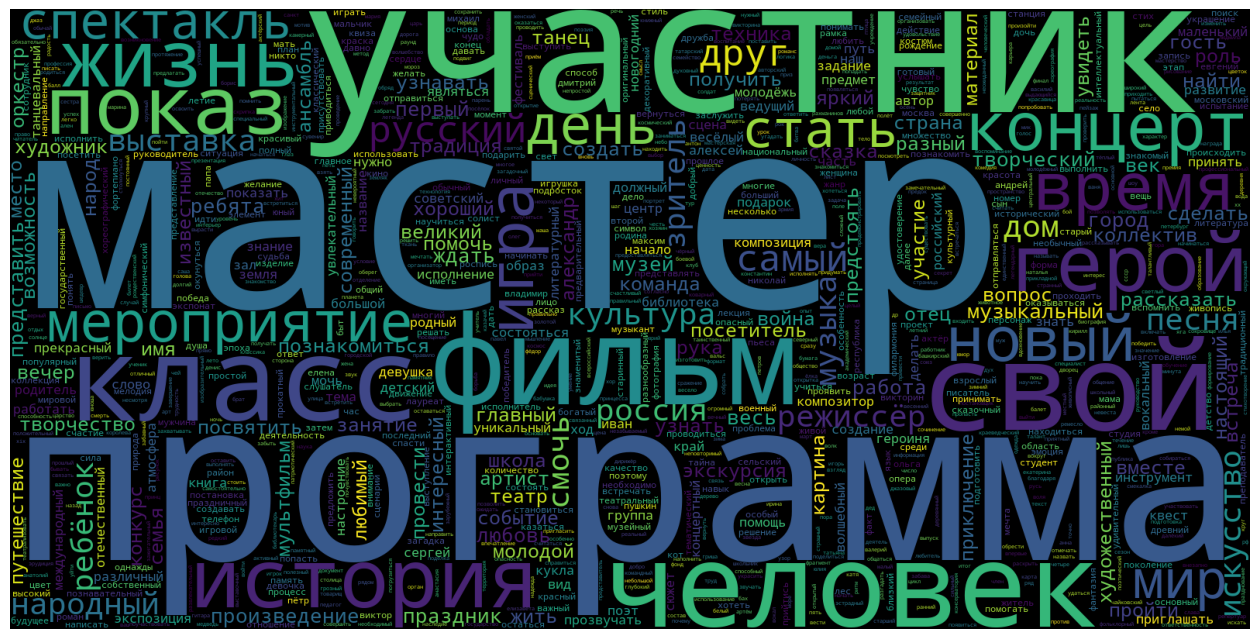

In [28]:
wc = WordCloud(
    max_words=1000, width=1600,
    height=800, collocations=False
    ).generate(" ".join(Texts))
plt.figure(figsize = (16,10))
plt.axis('off')
plt.imshow(wc);

In [84]:
# Инициализируем векторизатор
Tfidf_model = TfidfVectorizer()

Трансформируем наши описания в матрицу:

In [85]:
feature_matrix = Tfidf_model.fit_transform(Texts)

In [119]:
# Отбираем вектор ранее выбранного мероприятия
first_event_ftrs = feature_matrix[first_event_id]
print('размер выбранного вектора:', first_event_ftrs.shape)
# Отбор подвыборки из матрицы фичей мероприятий по индексам
subset_ftrs = feature_matrix[indices]
print('размер получившейся подвыборки:', subset_ftrs.shape)

размер выбранного вектора: (1, 314328)
размер получившейся подвыборки: (534, 314328)


Теперь необходимо вычислить косинусную схожесть. Можно сделать это так:

In [120]:
# Вычисляем косинусное сходство
Tfidf_cosine_sim = linear_kernel(first_event_ftrs, subset_ftrs)

In [121]:
get_cossim_recs(
    events0, indices, Tfidf_cosine_sim, dem_columns,
    first_event_id, n_recs=5, comment='Tfidf'
)

'Мероприятие, на которое мы уже сходили:'

,organization.name,name,description,places[0].locale.name,seances[0].start
504517,ГБУК г. Москвы «Московский театр кукол»,Спектакль «Сказка о глупом мышонке»,<p><span>В рамках гастролей </span><span>Липецкого государственного театра кукол</span><span></span></p> <p><span>Спектакль по мотивам сказок К.И. Чуковского</span></p> <p><span>Сказки Корнея Чуко...,Москва,2024-05-03 08:00:00


'Первые 5 рекомендаций (Tfidf):'

,organization.name,name,description,places[0].locale.name,seances[0].start,cosine_similarity
497923,ФГБУК «Государственный музей истории российской литературы имени В.И. Даля (Государственный литературный музей)»,Лекция «Завещания Чуковского. К 55-летию со дня смерти»,"<p>Множественное число в названии этой беседы не случайно: на протяжении жизни Корней Иванович не раз задумывался о том, что именно он сумеет оставить после себя – многочисленной родне и немногочи...",Москва,2024-05-22 13:00:00,0.172570
547298,ГБУК г. Москвы «МКЗ «Зарядье»,Музыкально-литературная программа «Сказочник Страны Советов»,"<p> Музыкально-литературная программа<br />о творчестве К.И. Чуковского.</p><p> Владимир Кошевой, художественное слово<br />Максим Мещеряков, фортепиано <br /></p><p> </p><p>Артист Владимир Кошево...",Москва,2024-06-01 10:00:00,0.140609
659157,ГБУК г. Москвы «КЦ «Строгино»,Опера-сказка «Сказки Андерсена»,"<p> Театр имени Н. И. Сац представляет оперу «Сказки Андерсена». Этот удивительный спектакль, сплетающий самые яркие истории из творчества Ганса Христиана Андерсена, вдохновлен новаторским подходо...",Москва,2024-05-12 15:00:00,0.128317
532509,Московский музыкальный театр «Геликон-опера» под руководством Дмитрия Бертмана,Спектакль «Страна забытых сказок»,"<p>Сказки нужны всем, а музыкальные сказки – особенно! В «Геликоне» об этом знают и стараются создавать такие спектакли, которые увлекают детей и становятся настоящими хитами! </p><p>Итак, о чем ж...",Москва,2024-05-11 11:00:00,0.107325
698178,ФГБУК «Государственный музей истории российской литературы имени В.И. Даля (Государственный литературный музей)»,Кураторская экскурсия по выставке «Уроки Золотой Рыбки»,"<p>Сказки Пушкина прочно вошли в русскую культуру, хрестоматийные сюжеты знакомы всем с детства. Однако ряд современников поэта отзывался о его сказках довольно сдержанно, а порою и вовсе отрицате...",Москва,2024-05-21 09:00:00,0.094834


### TruncatedSVD(Tfidf)

In [53]:
# Уменьшаем размерность с помощью TruncatedSVD
svd = TruncatedSVD(n_components=100)  # количество компонент можно настроить
reduced_matrix = svd.fit_transform(feature_matrix)

In [54]:
print('размер reduced matrix:', reduced_matrix.shape)
# Отбираем вектор ранее выбранного мероприятия
first_event_reduced_ftrs = reduced_matrix[first_event_id]
print('размер reduced вектора:', first_event_reduced_ftrs.shape)
# Отбор подвыборки из матрицы фичей мероприятий по индексам
subset_reduced_ftrs = reduced_matrix[indices]
print('размер получившейся подвыборки:', subset_reduced_ftrs.shape)

размер reduced matrix: (743184, 100)
размер reduced вектора: (100,)
размер получившейся подвыборки: (534, 100)


In [55]:
# Вычисляем косинусное сходство
svd_cosine_sim = linear_kernel(
    first_event_reduced_ftrs.reshape(1, -1),
    subset_reduced_ftrs
    )

In [56]:
get_cossim_recs(
    events0, indices, svd_cosine_sim, dem_columns,
    first_event_id, n_recs=5, comment='TruncatedSVD(Tfidf)'
)

'Мероприятие, на которое мы уже сходили:'

,organization.name,name,description,places[0].locale.name,seances[0].start
504517,ГБУК г. Москвы «Московский театр кукол»,Спектакль «Сказка о глупом мышонке»,"В рамках гастролей Липецкого государственного театра кукол Спектакль по мотивам сказок К.И. Чуковского Сказки Корнея Чуковского «Доктор Айболит», «Телефон» и «Бармалей» легли в основу этого яркого...",Москва,2024-05-03 08:00:00


'Первые 5 рекомендаций (TruncatedSVD(Tfidf)):'

,organization.name,name,description,places[0].locale.name,seances[0].start,cosine_similarity
659157,ГБУК г. Москвы «КЦ «Строгино»,Опера-сказка «Сказки Андерсена»,"Театр имени Н. И. Сац представляет оперу «Сказки Андерсена». Этот удивительный спектакль, сплетающий самые яркие истории из творчества Ганса Христиана Андерсена, вдохновлен новаторским подходом к...",Москва,2024-05-12 15:00:00,0.075380
532509,Московский музыкальный театр «Геликон-опера» под руководством Дмитрия Бертмана,Спектакль «Страна забытых сказок»,"Сказки нужны всем, а музыкальные сказки – особенно! В «Геликоне» об этом знают и стараются создавать такие спектакли, которые увлекают детей и становятся настоящими хитами! Итак, о чем же спектакл...",Москва,2024-05-11 11:00:00,0.072663
645703,ГБУК г. Москвы «ОКЦ ЮВАО»,Пластический спектакль «Маленький принц»,"Пластический спектакль по мотивам известной философской сказки – одноименного произведения Антуана де Сент-Экзюпери. Это рассказ о чем-то важном для каждого: о крепкой дружбе и большой любви, о вы...",Москва,2024-05-19 16:00:00,0.072645
423472,ГБУК г. Москвы «ММЭТ п/р В. Спесивцева»,Спектакль «Мертвые души»,"Язык Гоголя – его остроумный, тонкий, очень вкусный русский язык, по мнению многих критиков, особенно полно раскрылся в поэме «Мертвые души». Спектакль, поставленный Вячеславом Спесивцевым, – ярки...",Москва,2024-05-29 16:00:00,0.071557
654676,ГБУК г. Москвы «Объединение культурных центров Южного административного округа»,Спектакль «Слоненок»,"Спектакль театра кукол «КуБирТе» по мотивам сказки Редьярда Киплинга. Доверчивый и любопытный слоненок познает мир. Однажды он решил узнать, что кушает на обед крокодил. Но его любознательность сы...",Москва,2024-05-18 14:00:00,0.070520


## Рекомендации после n-го

Мы смоделировали такую ситуацию, где юзер посетил один какой-то ивент и получил рекомендации посетить ещё несколько других, вектора признаков которых схожи с вектором первого.

Но а что нам делать потом, когда пользователь сходит на второе мероприятие? Делать рекомендацию лишь по последнему посещению очень просто, но такой способ не позволит нам построить более содержательную репрезентацию предпочтений пользователя. Более того, при рекомендациях по последнему посещению вероятны повторные рекомендации тех же мероприятий, на которые человек уже ходил до последнего (в случае, если культурные мероприятия проводятся повторно).

Есть выход: можно вычислить средний вектор для всех посещенных мероприятий, если мы запомнили индексы векторов тех из них, которые пользователь посетил. Это нам позволит создать некоторый "профиль" последнего на основе его предпочтений.

Однако, если количество посещённых мероприятий становится большим, использование простого среднего вектора может привести к тому, что (1) старые мероприятия будут влиять на профиль пользователя слишком сильно, или к тому, что (2) из вектора предпочтений пользователя будет вымываться его специфичность. Чтобы учесть временной фактор и дать больший вес недавно посещённым мероприятиям, можно использовать подход с взвешиванием.

Мы можем присвоить каждому вектору мероприятия вес в зависимости от того, как давно пользователь его посетил. Например, можно использовать экспоненциальное затухание, где более свежие посещения имеют больший вес. И, вместо простого среднего вектора, мы вычислим взвешенное среднее.

### Демонстрация расчёта весов для векторов с помощью экспоненциального затухания

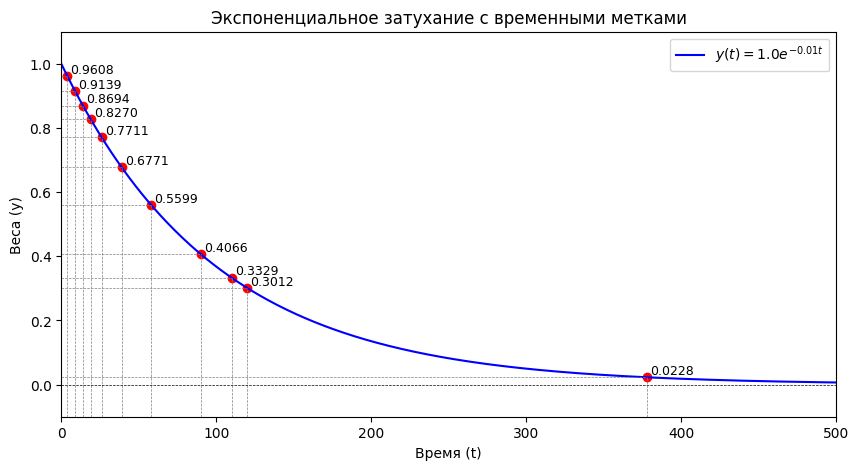

In [95]:
def plot_exponential_decay_with_points(timestamps, A=1.0, k=1/100, t_max=1000, density=None):
    """Генерация временных точек
    Args:
        timestamps (_type_): Метки времени
        A (float, optional): Начальная амплитуда. Defaults to 1.0.
        k (_type_, optional): Коэффициент затухания. Defaults to 1/100.
        t_max (int, optional): Дальность отрисовки. Defaults to 1000.
        density (int, optional): Плотность точек. Defaults to None.

    Returns:
        Выводит графику
        dict: словарь с метками времени и соответствующими им весами
    """
    # Временные точки от 0 до t_max
    if density:
        t = np.linspace(0, t_max, density)
    else:
        t = np.linspace(0, t_max, t_max)
    # Вычисление значений экспоненциального затухания
    y = A * np.exp(-k * t)
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label=f'$y(t) = {A} e^{{-{k}t}}$', color='blue')
    # Словарь соответствия весов временным меткам
    weights = {}

    # Добавление значений из списка для оси X
    for time in timestamps: 
        # Находим вес, соответствующий времени
        weight = A * np.exp(-k * time)
        weights[time] = weight
        plt.scatter(time, weight, color='red')
        plt.axhline(weight, color='gray', linestyle='--',
                    lw=0.5, xmin=0, xmax=time/t_max)
        plt.plot([time, time], [-0.1, weight], color='gray', linestyle='--', lw=0.5)
        plt.text(time + 2, weight, f'{weight:.4f}', fontsize=9, verticalalignment='bottom')

    plt.title('Экспоненциальное затухание с временными метками')
    plt.xlabel('Время (t)')
    plt.ylabel('Веса (y)')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.legend()
    plt.xlim(0, t_max)
    plt.ylim(-0.1, A * 1.1)
    plt.show()
    
    return weights

# Пример использования функции
timestamps = [4, 9, 14, 19, 26, 39, 58, 90, 110, 120, 378]
weights = plot_exponential_decay_with_points(timestamps, A=1.0, k=1/100, t_max=500)

Чем больше времени прошло с посещения конкретного мероприятия, тем меньше его вектор влияет на актуальный вектор пользовательских предпочтений.

Напишем класс User, внутри экземпляра которого и будет происходит расчёт вектора предпочтений пользователя на основе индексов мероприятий из таблицы.

In [181]:
class User:
    def __init__(self, events: pd.DataFrame, feature_matrix: np.ndarray):
        """
        Инициализация экземпляра User.

        :param events: Датафрейм с данными о мероприятиях.
        :param feature_matrix: Матрица признаков, описывающая мероприятия.
        """
        self.events = events
        self.feature_matrix = feature_matrix
        self.preference_vector = None

    def calculate_preference_vector(self, session_date: str, attended_indices: list, A=1.0, k=None):
        """
        Вычисляет вектор предпочтений пользователя на основе мероприятий, на которые он сходил.

        :param session_date: Дата сеанса пользователя в формате 'YYYY-MM-DD HH:MM:SS'.
        :param attended_indices: Список индексов мероприятий, на которые пользователь сходил.
        :param A: Начальная амплитуда.
        :param k: Коэффициент затухания.
        """
        self.attended_indices = attended_indices
        self.session_datetime = pd.to_datetime(session_date)
        sesiions_starts_values = self.events.iloc[self.attended_indices]['seances[0].start'].values
        days_diffs = []
        
        # Посчитаем временную разницу между сессией и посещениями
        for i in range(len(self.attended_indices)):
            time_delta = self.session_datetime - sesiions_starts_values[i]
            days_diffs.append(time_delta.days + round(time_delta.seconds / (24 * 3600), 3))
        
        if k is None:
            k = 1 / len(self.attended_indices)
        # Полчучаем веса векторов
        weights = A * np.exp(-k * np.array(days_diffs))
        # Получаем вектора мероприятий
        attended_features = self.feature_matrix[self.attended_indices]
        self.preference_vector = np.average(
            attended_features.toarray(), axis=0, weights=weights
            )
        return self.preference_vector

    def recommend_events(self, region: str, days_ahead: int):
        """
        Рекомендует мероприятия на основе косинусной схожести.

        :param region: Регион для фильтрации мероприятий.
        :param days_ahead: Количество дней для охвата предстоящих мероприятий.
        :return: Рекомендации в виде датафрейма.
        """
        # Преобразуем строку даты в объект datetime
        end_date = self.session_datetime + pd.Timedelta(days=days_ahead)

        # Фильтруем мероприятия по дате и региону
        filtered_events = self.events[
            (self.events['seances[0].start'] > self.session_datetime) &
            (self.events['seances[0].start'] <= end_date) &
            (self.events['places[0].address.region.name'] == region)
        ].copy()

        # Получаем индексы отфильтрованных мероприятий
        filtered_indices = filtered_events.index.tolist()
        filtered_feature_matrix = self.feature_matrix[filtered_indices]

        # Вычисляем косинусную схожесть
        if self.preference_vector is None:
            raise ValueError("Пожалуйста, сначала вычислите вектор предпочтений пользователя.")

        similarities = linear_kernel(
            self.preference_vector.reshape(1, -1),
            filtered_feature_matrix
            )[0]
        
        # Создаем DataFrame из сходств
        similarities_df = pd.DataFrame(similarities, columns=['similarity'])
        
        # Передаём подвыборке мероприятий значения схожестей
        filtered_events['similarity'] = similarities_df['similarity'].values
        
        # Сортируем по величине сходства и по дате
        sorted_events = filtered_events.sort_values(
            by=['similarity', 'seances[0].start'], ascending=[False, True]
            )

        # Отбираем уникальные мероприятия по 'name', оставляя те,
        # что имеют наиболее ранний 'seances[0].start'
        self.unique_events = sorted_events.drop_duplicates(subset=['name'], keep='first')
        
        # Возвращаем рекомендации в виде датафрейма
        return self.unique_events
    
    def display_recs(self, n_recs=5, comment='', columns=None):
        """
        Выводим в виде датафреймов посещенные и рекомендованные мероприятия.

        :n_recs: Первые N рекомендаций.
        :comment: Особый комментарий.
        :columns: Список колонок к выводу.
        """
        if columns is None:
            columns = self.events.columns.to_list()
        pd.set_option('display.max_colwidth', 200)
        display('Мероприятия, на которые мы уже сходили:')
        display(self.events.iloc[self.attended_indices][dem_columns])
        display(f'Первые {n_recs} рекомендаций ({comment}):')
        display(self.unique_events[[*dem_columns, 'similarity']][:n_recs])
        pd.set_option('display.max_colwidth', 50)

Проверим работу класса, выбрав перед этим индексы понравившихся мероприятий: мы имитируем историю посещений.

In [178]:
# Задаём регион
selected_region = 'Москва'
# Задаём временной промежуток для выбора мероприятий
start_date = pd.to_datetime('2024-03-30 15:00:00')
end_date = pd.to_datetime('2024-05-03 16:00:00')
start_mask = events0['seances[0].start'] > start_date
end_mask = events0['seances[0].start'] <= end_date
region_mask = events0['places[0].address.region.name'] == selected_region
filtered_events = events0[
    start_mask & end_mask & region_mask
    ].sort_values(by=['seances[0].start'], ascending=[True])
print(filtered_events.shape[0], 'строк на выбор')
pd.set_option('display.max_colwidth', None)
# Тут можно подобрать "окно скроллинга"
display(filtered_events[dem_columns][680:683])
pd.set_option('display.max_colwidth', 50)

686 строк на выбор


,organization.name,name,description,places[0].locale.name,seances[0].start
470057,ФГБОУ ВО «Московская государственная консерватория им. П. И. Чайковского»,Концерт Василисы Крыловой,"<p>Для вас выступит ассистент-стажер Московской государственной консерватории Василиса Крылова (скрипка). Руководитель – профессор С. И. Кравченко (член жюри многих известных престижных конкурсов: Международный конкурс им. Чайковского, Международный юношеский конкурс им. Чайковского (председатель), Международный конкурс им. Ойстраха, Международный конкурс им. Брамса, Международный конкурс им. Энеску, Международный конкурс им. Лысенко и др.).</p><p>Партия фортепиано – Мадина Набиуллина. </p><p> </p> <p>В программе:</p><p> </p><ul><li>М. Равель. Соната № 1 для скрипки и фортепиано, М 12;</li><li>П. Чайковский. Концерт ре мажор, соч. 35;</li><li>А. Пярт. Fratres для скрипки и фортепиано.</li></ul>",Москва,2024-05-03 16:00:00
572865,ГБУК «Москонцерт»,Концерт «Музыка галантной Европы»,"<p> В европейском искусстве XVIII век ознаменовался не только расцветом крупных форм, таких как опера, симфония и инструментальный концерт, но и многими изящными находками в области миниатюры. На концерте солисты «Москонцерта» представят грациозную коллекцию миниатюр, которые в разных жанрах и для разных инструментов были произведены композиторами Италии, Франции, Германии. Слушателей ждут любопытные версии «смысловых перекличек» между такими разными авторами, как Мауро Джулиани, Антонио Вивальди, Никколо Паганини, Франсуа Куперен и Иоганн Пахельбель, создавшими произведения для гитары, клавесина, скрипки, виолончели. </p>",Москва,2024-05-03 16:00:00
470066,ФГБОУ ВО «Московская государственная консерватория им. П. И. Чайковского»,Концерт-открытие фестиваля «Дню Победы посвящается...»,"<p> Теме памяти, связи поколений посвящена программа, открывающая фестиваль «Дню Победы посвящается...». На главной сцене, в большом зале консерватории выступит прославленный Академический ансамбль песни и пляски Российской армии, носящий имя легендарного профессора Московской государственной консерватории, композитора и хорового дирижера, автора гимна России Александра Васильевича Александрова. </p><p>В программе – избранные песни военных лет.</p><p> Фестиваль несет созидательную энергию и поддерживает связь поколений, рассказывая публике о героическом прошлом страны с помощью выразительных мелодий, симфонической музыки и лучших образцов искусства сегодняшнего дня. <br /></p>",Москва,2024-05-03 16:00:00


In [179]:
# Заносим индексы в список
attended_indices=[531252, 641271, 497884, 572865]

In [185]:
# Пример использования
user = User(events0, feature_matrix)

user.calculate_preference_vector(
    session_date='2024-05-10 15:00:00',
    attended_indices=attended_indices
    )
recommendations = user.recommend_events(region='Москва', days_ahead=30)

user.display_recs(n_recs=5, comment='tfidf', columns=dem_columns)

'Мероприятия, на которые мы уже сходили:'

,organization.name,name,description,places[0].locale.name,seances[0].start
531252,ГБУК г. Москвы «МКЗ «Зарядье»,Концерт «Римский-Корсаков – 180»,<p> Государственная академическая симфоническая капелла России<br />Дирижер – Валерий Полянский </p><p></p><p>Увертюра «Светлый праздник» – это уникальное явление в российской симфонической музыке...,Москва,2024-03-30 16:00:00
641271,ГБУК г. Москвы «Московский театр на Таганке»,Спектакль «Свадьба»,"<p>Спектакль Александра Карпушина «Свадьба» поставлен по мотивам одноименного киносценария Павла Лунгина и Александра Галина.</p><p>Первый вальс сорван, годы потеряны, встреча внезапная… Монетка п...",Москва,2024-04-06 16:00:00
497884,Государственное бюджетное учреждение культуры города Москвы «Объединение «Выставочные залы Москвы»,Выставка «Биология»,"<p>Концепция произведений заключается во взаимодействии природно-биологических звеньев и того, что является рукотворным, то есть тем, что создано человеком в процессе индустриального пути. Кинетич...",Москва,2024-04-25 08:00:00
572865,ГБУК «Москонцерт»,Концерт «Музыка галантной Европы»,"<p> В европейском искусстве XVIII век ознаменовался не только расцветом крупных форм, таких как опера, симфония и инструментальный концерт, но и многими изящными находками в области миниатюры. На ...",Москва,2024-05-03 16:00:00


'Первые 5 рекомендаций (tfidf):'

,organization.name,name,description,places[0].locale.name,seances[0].start,similarity
729245,ГБУК «Москонцерт»,Концерт «Паганини. Триптих. Вечер #2»,"<p> Приглашаются все желающие на второй из концертов проекта «Паганини. Триптих», посвященного знаменитому циклу «24 каприса» великого скрипача-виртуоза и композитора Никколо Паганини. Каждый из в...",Москва,2024-05-21 16:00:00,0.142925
596464,АНО «Музей военной истории «Российского военно-исторического общества»,Концерт «Музыкальные акценты»,<p> Вы привыкли видеть на сцене большие струнные ансамбли – струнный оркестр или струнный квартет. Их звучание уже давно полюбилось слушателям и оформилось в некую музыкальную традицию. А существу...,Москва,2024-05-16 16:00:00,0.108064
596453,АНО «Музей военной истории «Российского военно-исторического общества»,Концерт «Любовь – волшебная страна»,"<p>Если вы хотите провести вечер, наслаждаясь музыкой для гитары всевозможных разнообразных жанров и стилей, то в этом вам поможет концерт «Любовь – волшебная страна». На этом музыкальном вечере п...",Москва,2024-05-26 14:00:00,0.101484
649243,ФГБОУ ВО «Московская государственная консерватория им. П. И. Чайковского»,Концерт «Студенческая весна в Московской консерватории»,"<p>На сцену выйдут Мария Акопян (сопрано), Валерий Макаров (тенор), Дарья Никитченко (фортепиано), Юрий Моисеев (фортепиано), Александр Папушев (скрипка), Пак Сехо (виолончель), Илья Яшин (виолонч...",Москва,2024-05-12 16:00:00,0.099157
557689,ГБУК «Москонцерт»,Гала-концерт «Пушкин. Дуэль романсов»,<p> В год 225-летия Александра Сергеевича Пушкина «Москонцерт» осуществил тематический проект. В рамках цикла из восьми вечеров проходили «встречи» произведений разных композиторов на одни и те же...,Москва,2024-05-26 16:00:00,0.097073


Как бы там в итоге ни было, рекомендации, независимо от их точности, могут сыграть в психологическую шутку с пользователем: человек вдруг может начать интересоваться тем, мимо чего он легко бы прошёл, не будь персональной рекомендации. Если, конечно, не имеет заранее определённое убеждение в отношении честности системы.